In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import math as M


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/Users/flywire/Desktop/sci/dihiggsMLProject/')
from utils.commonFunctions import *

In [2]:
def trainBDT(X, y, X_val, y_val, param):

    evallist = [(X, y), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X, y.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)
    results = model.evals_result()
    ypred = model.predict(X_val)
    predictions = [round(value) for value in ypred]
    accuracy = accuracy_score(y_val, predictions)
    print("The training accuaracy is: {}".format(accuracy))
    conf_matrix = confusion_matrix(y_val, predictions)
    print("The confusion matrix: {}".format(conf_matrix))
    print("The precision is: {}".format(precision_score(y_val, predictions)))
    plot_BDTScore(X_val.copy(), y_val.copy(), model)
    return


def plot_BDTScore(X_val, y_val, model):
    sig_index = np.asarray(np.where(y_val==1))[0,:]
    bkg_index = np.asarray(np.where(y_val==0))[0,:]
    X_sig = X_val[sig_index,:]
    X_bkg = X_val[bkg_index,:]
    pred_sig = model.predict_proba(X_sig)[:,1]
    pred_bkg = model.predict_proba(X_bkg)[:,1]
    returnBestCutValue('BDT',pred_sig.copy(), pred_bkg.copy(), _testingFraction=0.3)
    plt.hist(pred_sig, bins=100, alpha=0.5, density=True, label="signal")
    plt.hist(pred_bkg, bins=100, alpha=0.5, density=True, label="background")
    plt.legend(loc="best")
    plt.title("BDT score")
    plt.show()
    
    
    
def plot_learning_curve(X, y, param, nClus):
    train_sizes, train_scores, test_scores = learning_curve(xgb.XGBClassifier(**param), X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")
    plt.legend(loc="best")
    plt.title("{} clusters learning curve".format(nClus))
    plt.show()
    
def plotCostFunc_kClus(data, nClus):
    #find out the "best" value of n_clusters to perform k-means clustering
    cost = []
    for i in range(1,nClus+1):
        ki = KMeans(n_clusters=i, random_state=0).fit(data)
        cost.append(ki.inertia_)
    plt.plot(range(1,nClus+1),cost, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('cost function')
    plt.show()
    

def KClustering(X, y, X_test, y_test, nClusters, usePCA, n_vars):
    if(usePCA):
        #process data with PCA
        #find the number of features that keep 95% variance
        print("Doing PCA...")
        variance_threshold = 0.85
        num_components = n_vars
        pca_trail = PCA()
        pca_trail.fit(X)
        var = np.cumsum(pca_trail.explained_variance_ratio_)
        for n_com in range(1,len(var)-1):
            if(var[n_com]>variance_threshold):
                num_components = n_com
                break

        print("Doing k-means clustering with {0} features...".format(num_components))
        pca = PCA(n_components=num_components)
        pca.fit(X)
        X_train_pca = pca.transform(X)
        X_test_pca = pca.transform(X_test)
        print("Shape of new training dataset: {}".format(X_train_pca.shape))
        print("Shape of new testing dataset: {}".format(X_test_pca.shape))
        #do the k-means clustering
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X_train_pca)
        score_train = kmeans.transform(X_train_pca)
        score_test = kmeans.transform(X_test_pca)
    else:
        #do k-means clustering
        print("Doing k-means clustering...")
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X)
        score_train = kmeans.transform(X)
        score_test = kmeans.transform(X_test)
        
    score_train_norm = scale(score_train)
    score_test_norm = scale(score_test)
    y_np = y.to_numpy()
    y_test_np = y_test.to_numpy()
    print("Finished clustering. :)")
    
    return score_train_norm, y_np, score_test_norm, y_test_np


def CalcError(N_sig, N_bkg):
    e_s = M.sqrt(N_sig)
    e_b = (M.sqrt(N_bkg))/(2*M.sqrt(N_bkg))
    sig = N_sig/M.sqrt(N_bkg)
    e_sig = (N_sig/M.sqrt(N_bkg))*M.sqrt((e_s/N_sig)*(e_s/N_sig) + (e_b/M.sqrt(N_bkg))*(e_b/M.sqrt(N_bkg)))
    return sig, e_sig
    
print(CalcError(3621.0,1.97e+07))
print(CalcError(1415.5,1.67e+06))
print(CalcError(2082.7,1.61e+06))
print(CalcError(1723.0,1.06e+06))
print(CalcError(1206.6,4.99e+05))

(0.8158219983519223, 0.01355785944985763)
(1.0953467856520709, 0.02911673743552576)
(1.6413975430741747, 0.035972501112919684)
(1.6735255408415661, 0.040325329976003285)
(1.7080990383023162, 0.049188390873821396)


In [3]:
# *** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()
print(hh_raw)
print(qcd_raw)

# *** 2. Make mix of dihiggs and QCD for specified variables
#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
#variables = ['hh_mass', 'h1_mass', 'h2_mass']
variables = list(qcd_raw.columns.values)
variables.remove('isSignal')
variables.remove('isMatchable')
remove_list = []
for var in variables:
    if((var.find('reco')!=-1) or ( (var.find('jet')!=-1) and (var.find('_')!=-1) ) ):
        remove_list.append(var)
#print(remove_list)
for r_var in remove_list:        
    variables.remove(r_var)
    
print(variables)

data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables, testingFraction)
data_train_norm = scale(data_train)
data_test_norm = scale(data_test)
print(data_train)
print(data_test)



          hh_mass     h1_mass     h2_mass       hh_pt       h1_pt       h2_pt  \
0      458.812645   91.242908  101.760521  226.379068  236.897507  219.529744   
1      205.300613   94.731575   66.181342  285.467429  254.031375   44.328652   
2      312.195672   35.009352   76.545040   47.135284  121.966993  113.022115   
3      256.653686  120.919577  130.666414  104.352810   24.389205   80.279124   
4      338.309957  123.030238  100.686457  123.252896  195.409763   76.493313   
...           ...         ...         ...         ...         ...         ...   
78871  368.286751  150.629851  112.730540   33.405608  128.436554   96.252651   
78872  247.227346  108.873723  106.094694  104.984449   98.204886   55.381481   
78873  286.250983  127.981149  115.669728  110.007804  129.576236   39.177808   
78874  348.253502   89.256385  110.704939   58.768636   56.484501   17.970202   
78875  480.276005   91.285274  140.168706   57.327226  233.536761  183.269844   

       deltaR(h1, h2)  delt

In [ ]:
# *** Find out the "best" value of n_clusters to perform k-means clustering
#plotCostFunc_kClus(data_train_norm,100)
#plotCostFunc_kClus(data_train_pca)

In [5]:
# *** Do the k-means clustering
#nClus = 40    # can try 15 20 40
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, False, len(variables))
#score_pcakm_train_norm,labels_train_np,score_pcakm_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
score_km_train_norm = data_train_norm
labels_train_np = labels_train.to_numpy()
score_km_test_norm = data_test_norm
labels_test_np = labels_test.to_numpy()

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.766467	validation_1-auc:0.764487
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.796758	validation_1-auc:0.796065
[2]	validation_0-auc:0.818654	validation_1-auc:0.817563
[3]	validation_0-auc:0.824801	validation_1-auc:0.823782
[4]	validation_0-auc:0.833623	validation_1-auc:0.832105
[5]	validation_0-auc:0.839185	validation_1-auc:0.837329
[6]	validation_0-auc:0.841555	validation_1-auc:0.839738
[7]	validation_0-auc:0.843567	validation_1-auc:0.841931
[8]	validation_0-auc:0.845967	validation_1-auc:0.843747
[9]	validation_0-auc:0.848644	validation_1-auc:0.846187
[10]	validation_0-auc:0.849624	validation_1-auc:0.847258
[11]	validation_0-auc:0.850427	validation_1-auc:0.847911
[12]	validation_0-auc:0.851163	validation_1-auc:0.848413
[13]	validation_0-auc:0.852755	validation_1-auc:0.850043
[14]	validation_0-auc:0.853425	validation_1-auc:0.85079

[142]	validation_0-auc:0.883988	validation_1-auc:0.874094
[143]	validation_0-auc:0.884123	validation_1-auc:0.874169
[144]	validation_0-auc:0.884192	validation_1-auc:0.874155
[145]	validation_0-auc:0.884275	validation_1-auc:0.874194
[146]	validation_0-auc:0.884364	validation_1-auc:0.874215
[147]	validation_0-auc:0.884462	validation_1-auc:0.874296
[148]	validation_0-auc:0.884489	validation_1-auc:0.874308
[149]	validation_0-auc:0.884614	validation_1-auc:0.874416
[150]	validation_0-auc:0.884668	validation_1-auc:0.874409
[151]	validation_0-auc:0.884707	validation_1-auc:0.874396
[152]	validation_0-auc:0.884756	validation_1-auc:0.874405
[153]	validation_0-auc:0.884927	validation_1-auc:0.874588
[154]	validation_0-auc:0.885004	validation_1-auc:0.87463
[155]	validation_0-auc:0.885032	validation_1-auc:0.874625
[156]	validation_0-auc:0.885154	validation_1-auc:0.874728
[157]	validation_0-auc:0.885214	validation_1-auc:0.874759
[158]	validation_0-auc:0.885295	validation_1-auc:0.874763
[159]	validatio

[284]	validation_0-auc:0.892462	validation_1-auc:0.876645
[285]	validation_0-auc:0.892525	validation_1-auc:0.876621
[286]	validation_0-auc:0.892591	validation_1-auc:0.876596
[287]	validation_0-auc:0.892626	validation_1-auc:0.876585
[288]	validation_0-auc:0.89268	validation_1-auc:0.876589
[289]	validation_0-auc:0.892759	validation_1-auc:0.876535
[290]	validation_0-auc:0.892803	validation_1-auc:0.876539
[291]	validation_0-auc:0.892837	validation_1-auc:0.876551
[292]	validation_0-auc:0.892909	validation_1-auc:0.876595
[293]	validation_0-auc:0.892973	validation_1-auc:0.87658
[294]	validation_0-auc:0.892997	validation_1-auc:0.8766
[295]	validation_0-auc:0.89309	validation_1-auc:0.876602
[296]	validation_0-auc:0.893137	validation_1-auc:0.876616
[297]	validation_0-auc:0.893187	validation_1-auc:0.876628
[298]	validation_0-auc:0.893261	validation_1-auc:0.876636
[299]	validation_0-auc:0.893322	validation_1-auc:0.876616
The training accuaracy is: 0.7984468339307049
The confusion matrix: [[29937  

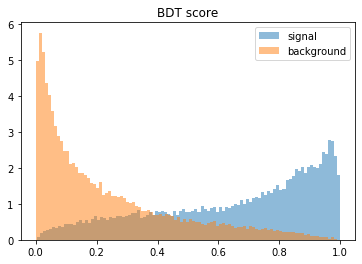

In [7]:

# *** Define parameters for BDT
param = {
    'learning_rate': 0.3,
    'n_estimators': 300,
    'max_depth': 3,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param)



In [7]:
# *** tune the classifier
# *** tune the tree parameters first
param_test1 = {
    #'max_depth': range(1,10,2),
    'max_depth': [2,3,4,5,6,7,8,9,10,11],
    'min_child_weight': range(0,6,2)
}
#cv = StratifiedKFold(5)
cv = KFold(5)
gsearch = GridSearchCV(xgb.XGBClassifier(**param), param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch.fit(score_km_train_norm, labels_train_np)
#print("The cv results: {}".format(gsearch.cv_results_))
print("The best paramter: {}".format(gsearch.best_params_))
#print("The best score: {}".format(gsearch.best_score_))

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'max_depth': 11, 'min_child_weight': 0}


In [ ]:
# *** tune tree parameters more precisely
param_test2 = {
    'max_depth': [8,9,10]
    #'min_child_weight': [1,2]
}
gsearch2 = GridSearchCV(xgb.XGBClassifier(**param), param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch2.cv_results_))
print("The best paramter: {}".format(gsearch2.best_params_))
#print("The best score: {}".format(gsearch2.best_score_))

In [10]:
# *** tune gamma
param_test3 = {
    #'gamma': [0,0.3,0.5,0.7]
    'gamma': [0.1,0.2,0.3,0.4]
}
param_new1 = {
    'learning_rate': 0.3,
    #'eta': 0.3,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
    #'seed': 27
    #'objective': 'multi:softprob',
    #'num_class': 2
}
gsearch3 = GridSearchCV(xgb.XGBClassifier(**param_new1), param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch3.cv_results_))
print("The best paramter: {}".format(gsearch3.best_params_))
#print("The best score: {}".format(gsearch3.best_score_))

/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'gamma': 0.1}


[0]	validation_0-auc:0.832444	validation_1-auc:0.789049
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.851641	validation_1-auc:0.803411
[2]	validation_0-auc:0.863148	validation_1-auc:0.809004
[3]	validation_0-auc:0.872124	validation_1-auc:0.814502
[4]	validation_0-auc:0.87849	validation_1-auc:0.817091
[5]	validation_0-auc:0.884105	validation_1-auc:0.818924
[6]	validation_0-auc:0.890605	validation_1-auc:0.820989
[7]	validation_0-auc:0.895982	validation_1-auc:0.82278
[8]	validation_0-auc:0.899164	validation_1-auc:0.823502
[9]	validation_0-auc:0.903364	validation_1-auc:0.824652
[10]	validation_0-auc:0.906245	validation_1-auc:0.825171
[11]	validation_0-auc:0.90927	validation_1-auc:0.825452
[12]	validation_0-auc:0.91096	validation_1-auc:0.825916
[13]	validation_0-auc:0.913329	validation_1-auc:0.826599
[14]	validation_0-auc:0.914183	validation_1-auc:0.826783
[1

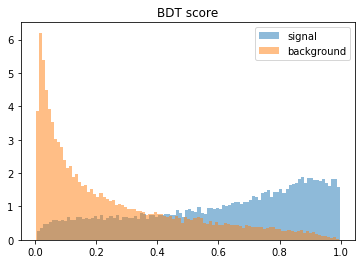

In [11]:

# *** see how the new model performs
param_new2 = {
    'learning_rate': 0.3,
    #'n_estimator': 1000,
    #'eta': 0.3,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param_new2)

In [12]:
# *** tune subsample and colsample_bytree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)]
    #'colsample_bytree':[0.9,1.0],
    #'subsample': [0.9,1.0]
}
gsearch4 = GridSearchCV(xgb.XGBClassifier(**param_new2), param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch4.cv_results_))
print("The best paramter: {}".format(gsearch4.best_params_))
#print("The best score: {}".format(gsearch4.best_score_))


/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'colsample_bytree': 0.9, 'subsample': 1.0}


In [16]:
# *** tune alpha
param_test5 = {
    #'reg_alpha': [1e-05,1e-02,0.1,1,100],
    #'reg_lambda': [0,3,5,7,9]
    'reg_alpha': [0.7,1,1,2],
    'reg_lambda': [8,9,10]
}
param_new3 = {
    'learning_rate': 0.3,
    #'n_estimator': 1000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

gsearch5 = GridSearchCV(xgb.XGBClassifier(**param_new3), param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch5.cv_results_))
print("The best paramter: {}".format(gsearch5.best_params_))
#print("The best score: {}".format(gsearch5.best_score_))



/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best paramter: {'reg_alpha': 2, 'reg_lambda': 10}


[0]	validation_0-auc:0.874365	validation_1-auc:0.849643
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.883208	validation_1-auc:0.856548
[2]	validation_0-auc:0.88742	validation_1-auc:0.858982
[3]	validation_0-auc:0.890004	validation_1-auc:0.860742
[4]	validation_0-auc:0.892323	validation_1-auc:0.862151
[5]	validation_0-auc:0.89473	validation_1-auc:0.863674
[6]	validation_0-auc:0.896715	validation_1-auc:0.864728
[7]	validation_0-auc:0.898646	validation_1-auc:0.866003
[8]	validation_0-auc:0.900647	validation_1-auc:0.866975
[9]	validation_0-auc:0.902264	validation_1-auc:0.867911
[10]	validation_0-auc:0.903938	validation_1-auc:0.868833
[11]	validation_0-auc:0.905275	validation_1-auc:0.869643
[12]	validation_0-auc:0.906788	validation_1-auc:0.87045
[13]	validation_0-auc:0.908292	validation_1-auc:0.871193
[14]	validation_0-auc:0.909791	validation_1-auc:0.871872
[

[142]	validation_0-auc:0.96563	validation_1-auc:0.888145
[143]	validation_0-auc:0.965709	validation_1-auc:0.888159
[144]	validation_0-auc:0.966208	validation_1-auc:0.888272
[145]	validation_0-auc:0.966421	validation_1-auc:0.888319
[146]	validation_0-auc:0.966554	validation_1-auc:0.888333
[147]	validation_0-auc:0.966847	validation_1-auc:0.88835
[148]	validation_0-auc:0.96688	validation_1-auc:0.888346
[149]	validation_0-auc:0.967045	validation_1-auc:0.888345
[150]	validation_0-auc:0.967101	validation_1-auc:0.888339
[151]	validation_0-auc:0.967158	validation_1-auc:0.888336
[152]	validation_0-auc:0.967177	validation_1-auc:0.888337
[153]	validation_0-auc:0.967226	validation_1-auc:0.888344
[154]	validation_0-auc:0.967267	validation_1-auc:0.888349
[155]	validation_0-auc:0.967573	validation_1-auc:0.888355
[156]	validation_0-auc:0.967645	validation_1-auc:0.888356
[157]	validation_0-auc:0.967698	validation_1-auc:0.888358
[158]	validation_0-auc:0.967832	validation_1-auc:0.888367
[159]	validation_

[284]	validation_0-auc:0.982114	validation_1-auc:0.889917
[285]	validation_0-auc:0.982196	validation_1-auc:0.889904
[286]	validation_0-auc:0.982325	validation_1-auc:0.889894
[287]	validation_0-auc:0.982508	validation_1-auc:0.889919
[288]	validation_0-auc:0.982652	validation_1-auc:0.889954
[289]	validation_0-auc:0.982724	validation_1-auc:0.889955
[290]	validation_0-auc:0.982881	validation_1-auc:0.889955
[291]	validation_0-auc:0.982984	validation_1-auc:0.889983
[292]	validation_0-auc:0.98314	validation_1-auc:0.890022
[293]	validation_0-auc:0.983201	validation_1-auc:0.890022
[294]	validation_0-auc:0.98322	validation_1-auc:0.890022
[295]	validation_0-auc:0.983265	validation_1-auc:0.890029
[296]	validation_0-auc:0.983356	validation_1-auc:0.890024
[297]	validation_0-auc:0.983467	validation_1-auc:0.890026
[298]	validation_0-auc:0.983487	validation_1-auc:0.890032
[299]	validation_0-auc:0.983494	validation_1-auc:0.890029
[300]	validation_0-auc:0.983617	validation_1-auc:0.890069
[301]	validation

[426]	validation_0-auc:0.990724	validation_1-auc:0.89101
[427]	validation_0-auc:0.990789	validation_1-auc:0.890999
[428]	validation_0-auc:0.990844	validation_1-auc:0.891011
[429]	validation_0-auc:0.990904	validation_1-auc:0.891022
[430]	validation_0-auc:0.990935	validation_1-auc:0.891044
[431]	validation_0-auc:0.990981	validation_1-auc:0.891031
[432]	validation_0-auc:0.990993	validation_1-auc:0.891025
[433]	validation_0-auc:0.991042	validation_1-auc:0.891033
[434]	validation_0-auc:0.991049	validation_1-auc:0.891028
[435]	validation_0-auc:0.991053	validation_1-auc:0.891022
[436]	validation_0-auc:0.991088	validation_1-auc:0.891043
[437]	validation_0-auc:0.991116	validation_1-auc:0.891043
[438]	validation_0-auc:0.991168	validation_1-auc:0.891062
[439]	validation_0-auc:0.99119	validation_1-auc:0.891061
[440]	validation_0-auc:0.99123	validation_1-auc:0.891063
[441]	validation_0-auc:0.991266	validation_1-auc:0.891068
[442]	validation_0-auc:0.991302	validation_1-auc:0.891091
[443]	validation_

[568]	validation_0-auc:0.995385	validation_1-auc:0.891847
[569]	validation_0-auc:0.9954	validation_1-auc:0.891849
[570]	validation_0-auc:0.995425	validation_1-auc:0.891843
[571]	validation_0-auc:0.995441	validation_1-auc:0.891853
[572]	validation_0-auc:0.995462	validation_1-auc:0.891845
[573]	validation_0-auc:0.995514	validation_1-auc:0.891846
[574]	validation_0-auc:0.995537	validation_1-auc:0.891859
[575]	validation_0-auc:0.995584	validation_1-auc:0.891862
[576]	validation_0-auc:0.995613	validation_1-auc:0.891851
[577]	validation_0-auc:0.995635	validation_1-auc:0.891873
[578]	validation_0-auc:0.995653	validation_1-auc:0.891878
[579]	validation_0-auc:0.995655	validation_1-auc:0.891875
[580]	validation_0-auc:0.995679	validation_1-auc:0.891885
[581]	validation_0-auc:0.995685	validation_1-auc:0.891882
[582]	validation_0-auc:0.995694	validation_1-auc:0.891875
[583]	validation_0-auc:0.995724	validation_1-auc:0.891895
[584]	validation_0-auc:0.995726	validation_1-auc:0.891894
[585]	validation

[710]	validation_0-auc:0.997579	validation_1-auc:0.89247
[711]	validation_0-auc:0.997585	validation_1-auc:0.892474
[712]	validation_0-auc:0.997591	validation_1-auc:0.892465
[713]	validation_0-auc:0.997606	validation_1-auc:0.892471
[714]	validation_0-auc:0.997634	validation_1-auc:0.892479
[715]	validation_0-auc:0.997665	validation_1-auc:0.892496
[716]	validation_0-auc:0.997675	validation_1-auc:0.892493
[717]	validation_0-auc:0.99768	validation_1-auc:0.892489
[718]	validation_0-auc:0.997692	validation_1-auc:0.892494
[719]	validation_0-auc:0.997704	validation_1-auc:0.892503
[720]	validation_0-auc:0.997716	validation_1-auc:0.892501
[721]	validation_0-auc:0.997728	validation_1-auc:0.892495
[722]	validation_0-auc:0.997736	validation_1-auc:0.892495
[723]	validation_0-auc:0.997751	validation_1-auc:0.892477
[724]	validation_0-auc:0.99776	validation_1-auc:0.892472
[725]	validation_0-auc:0.997773	validation_1-auc:0.892471
[726]	validation_0-auc:0.997786	validation_1-auc:0.892477
[727]	validation_

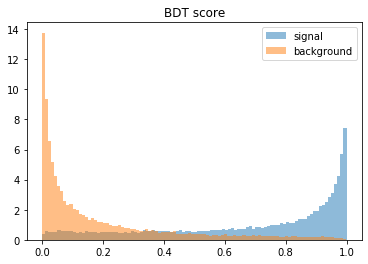

In [8]:
# *** see how the new model performs
param_new4 = {
    'eta': 0.1,
    'n_estimators': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param_new4)

In [8]:
_sw = getLumiScaleFactor( 0.3, _isDihiggs = True)
_bw = getLumiScaleFactor( 0.3, _isDihiggs = False)
e_sig = 1.57*M.sqrt(1/(1873.0/_sw) + 1/(4*(1418389.86/_bw)))
print(e_sig)

0.03584928797489655


In [5]:
'''

Original variables:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


parameter for 15 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


20 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1, 
    'reg_lambda': 10,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

40 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 3, 
    'reg_lambda': 5,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}



PCA:
15 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 6,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

20 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

40 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.5,
    'reg_alpha': 1, 
    'reg_lambda': 12,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
'''

"\nparameter for 15 clusters:\nparam_new4 = {\n    'eta': 0.1,\n    'n_estimator': 5000,\n    'max_depth': 11,\n    'min_child_weight': 0,\n    'subsample': 1.0,\n    'colsample_bytree': 0.8,\n    'gamma': 0,\n    'reg_alpha': 1, \n    'reg_lambda': 9,\n    'scale_pos_weight': 1,\n    'eval_metric': 'auc',\n    'objective': 'binary:logistic',\n    'random_state': 27\n}\n\n\n20 clusters:\nparam_new4 = {\n    'eta': 0.1,\n    'n_estimator': 5000,\n    'max_depth': 11,\n    'min_child_weight': 0,\n    'subsample': 1.0,\n    'colsample_bytree': 1.0,\n    'gamma': 0.5,\n    'reg_alpha': 1, \n    'reg_lambda': 10,\n    'scale_pos_weight': 1,\n    'eval_metric': 'auc',\n    'objective': 'binary:logistic',\n    'random_state': 27\n}\n\n40 clusters:\nparam_new4 = {\n    'eta': 0.1,\n    'n_estimator': 5000,\n    'max_depth': 11,\n    'min_child_weight': 0,\n    'subsample': 1.0,\n    'colsample_bytree': 1.0,\n    'gamma': 0.5,\n    'reg_alpha': 3, \n    'reg_lambda': 5,\n    'scale_pos_weight':

In [ ]:
# *** Plot the learning curve
plot_learning_curve(score_km_train_norm, labels_train_np, param, nClus)

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
#train the NN
nInputNodes = 3

model = Sequential()
model.add(Dense(10, input_dim=15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#history = model.fit(score_km_train_norm, labels_train, epochs=25, validation_split=0.25, batch_size=400)
history = model.fit(score_pcakm_train_norm, labels_train, epochs=25, validation_split=0.25, batch_size=400)

In [ ]:
history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])